In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import glob
from PIL import Image
from torchvision import datasets ,models , transforms
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, sampler, random_split
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import models
import pathlib
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# les chemin que nous allons utiliser:
path_data='/content/drive/MyDrive/OC Asma - Tahri/P06/Data/'
path_image= '/content/drive/MyDrive/OC Asma - Tahri/P06/Data/Flipkart/Images/'
path_res=path_res=path_image+'resized/'
path_multilabels=path_data+'Multi_labels/'

In [ ]:
# data préparé dans le notebook_03, ou nous avons les 1050 images etiquettées:
data = pd.read_csv(path_data+"data.csv",index_col=0)
data

,Home Furnishing,Baby Care,Watches,Home Decor & Festive Needs,Kitchen & Dining,Beauty and Personal Care,Computers
55b85ea15a1536d46b7190ad6fff8ce7.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6325b6870c54cd47be6ebfbffa620ec7.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
d4684dcdc759dd9cdf41504698d737d8.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
a4b09aa7927c59fbb39960b3d7919909.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
81e739c7f3be737152f2e6f520e3494b.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
9b805665a791f40e7946a73dcea17e35.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0
b5834f1e97c74d2833dbcb09a3f27926.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7815fb39feb773db944c9f03bbdcbf64.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0
d407ab825e1a266635214bfe893f29c4.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# les classes sur les quelles nous allons travailler:
classes_list=data.columns.tolist()
classes_list

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [ ]:
# chargement des 3 groupes préparés également dans le notebook_03:
train= pd.read_csv(path_data+'train.csv',index_col=0)
test=pd.read_csv(path_data+'test.csv',index_col=0)
valid=pd.read_csv(path_data+'valid.csv',index_col=0)

In [ ]:
train_dict = {}

for file_name,values in train.iterrows():
  labels=np.array(values)
  train_dict[file_name] = labels    

In [ ]:
labels=train_dict.values()
labels=list(labels)

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class MultiClassData(Dataset):
    
    def __init__(self, dataframe, folder_dir, transform = None):
        
        self.dataframe = dataframe
        self.folder_dir = folder_dir
        self.transform = transform
        self.file_names = dataframe.index
        self.labels = labels
        
        
    def __len__(self):
        return len(self.dataframe)
    
    
    def __getitem__(self, index):
        
        image = Image.open(os.path.join(self.folder_dir, self.file_names[index]))
        label = self.labels[index]
        sample = {'image': image, 'label': label.astype(float)}
        if self.transform:
            image = self.transform(sample['image'])
            sample = {'image': image, 'label': label.astype(float)}
        
        return sample

In [ ]:
# Application d'un transformer pour optimiser les resultast du densnet:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
transformer = transforms.Compose([transforms.ToTensor(),transforms.Resize(224),normalize])

In [ ]:
train_dl = MultiClassData(train,path_data+'train/', transform =transformer )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


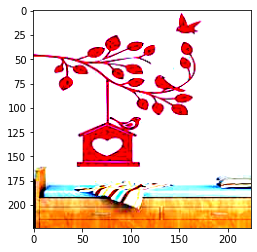

In [ ]:
plt.imshow(torchvision.utils.make_grid(train_dl[2]['image']).permute(1, 2, 0))

In [ ]:
(train_dl[2]['label'].astype(float))

array([0., 1., 0., 0., 0., 0., 0.])

In [ ]:
valid_dict = {}

for file_name,values in valid.iterrows():
  labels=np.array(values)
  valid_dict[file_name] = labels

In [ ]:
labels=valid_dict.values()
labels=list(labels)

In [ ]:
valid_dl = MultiClassData(valid,path_data+'val/', transform =transformer )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


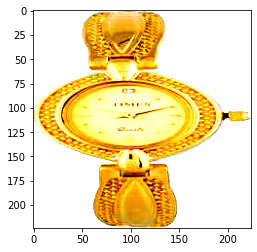

In [ ]:
plt.imshow(torchvision.utils.make_grid(valid_dl[2]['image']).permute(1, 2, 0))

In [ ]:
valid_dl[2]['label']

array([0., 0., 1., 0., 0., 0., 0.])

In [ ]:
test_dict = {}

for file_name,values in test.iterrows():
  labels=np.array(values)
  test_dict[file_name] = labels

In [ ]:
labels=test_dict.values()
labels=list(labels)

In [ ]:
test_dl = MultiClassData(test,path_data+'test/', transform =transformer )

In [ ]:
batch_size=2
train_loader = torch.utils.data.DataLoader(train_dl, shuffle = True, batch_size = batch_size, num_workers = 2)
valid_loader = torch.utils.data.DataLoader(valid_dl, shuffle = True, batch_size = batch_size, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dl, shuffle = True, batch_size = batch_size, num_workers = 2)

In [ ]:
device= torch.device("cuda"if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def pred_acc(original, predicted):
    return torch.round(predicted).eq(original).sum().numpy()/len(original)

In [ ]:
import time, copy

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    phases_to_process = np.intersect1d([*dataloaders.keys()], ["train", "val"])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in phases_to_process:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            previous_epoch = 0
            running_loss = 0.0
            running_total_corrects = 0.0
            running_total_global_pred = 0
            running_total_unitary_pred = 0.0
            running_total_full_corrects = 0.0

            # Iterate over data.
            for data in dataloaders[phase]:
                
         
                
                inputs = data['image'].float().to(device)
                labels = data['label'].float().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                        preds = outputs > torch.tensor([0.5]).to(device)
                    else:
                        outputs = model(inputs)
                        
                        loss = criterion(outputs, labels)
                        preds = outputs > torch.tensor([0.5]).to(device)
                        if previous_epoch != epoch:
                            
                            previous_epoch = epoch
                    

                    # training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_full_corrects =0.0
                for p,l in zip(preds,labels.data):
                    running_total_global_pred += 1
                    if torch.all(torch.eq(p,l)):
                        running_full_corrects += 1
                        
                running_total_full_corrects += running_full_corrects

                
            
                # per predictions
                running_corrects = float(torch.sum(torch.eq(preds,labels.data)))
                running_total_corrects += running_corrects
                running_total_unitary_pred += preds.shape[0]*preds.shape[1]

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_total_corrects / running_total_unitary_pred
            epoch_acc_full_correct = running_total_full_corrects / running_total_global_pred

            print('{} Loss: {:.4f} Acc: {:.4f} Acc_full_correct: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_acc_full_correct))


            # deep copy the model
            if phase == 'val' and epoch_acc_full_correct > best_acc:
                best_acc = epoch_acc_full_correct
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc_full_correct)

      

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
 
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet201(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            nn.Sigmoid()
        )
        input_size = 224

    return model_ft, input_size

In [ ]:
# Initialize the model for this run
feature_extract = False
model_ft, input_size = initialize_model("densenet", num_classes=7, feature_extract=feature_extract, use_pretrained=True)
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
# print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update,lr=0.0001)

criterion = nn.BCELoss()



Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.denseblock1.densela

In [ ]:
# ENtrainement du model sur 100 epochs et enregistrement du meilleur accuracy:
%%time
my_trained, val_acc_history  = train_model(model = model_ft, dataloaders = {"train":train_loader, "val":valid_loader},
                                           criterion = criterion, optimizer=optimizer_ft, num_epochs=100, is_inception=False)


Epoch 0/99
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.3282 Acc: 0.8750 Acc_full_correct: 0.2082
val Loss: 0.2102 Acc: 0.9177 Acc_full_correct: 0.6076
Epoch 1/99
----------
train Loss: 0.2556 Acc: 0.9178 Acc_full_correct: 0.4748
val Loss: 0.1851 Acc: 0.9313 Acc_full_correct: 0.6835
Epoch 2/99
----------
train Loss: 0.2125 Acc: 0.9359 Acc_full_correct: 0.5864
val Loss: 0.1959 Acc: 0.9241 Acc_full_correct: 0.6329
Epoch 3/99
----------
train Loss: 0.1855 Acc: 0.9499 Acc_full_correct: 0.6735
val Loss: 0.1880 Acc: 0.9367 Acc_full_correct: 0.7215
Epoch 4/99
----------
train Loss: 0.1619 Acc: 0.9613 Acc_full_correct: 0.7537
val Loss: 0.1755 Acc: 0.9412 Acc_full_correct: 0.7278
Epoch 5/99
----------
train Loss: 0.1463 Acc: 0.9687 Acc_full_correct: 0.7932
val Loss: 0.1533 Acc: 0.9494 Acc_full_correct: 0.7658
Epoch 6/99
----------
train Loss: 0.1134 Acc: 0.9769 Acc_full_correct: 0.8463
val Loss: 0.2198 Acc: 0.9394 Acc_full_correct: 0.7278
Epoch 7/99
----------
train Loss: 0.0979 Acc: 0.9811 Acc_full_correct: 0.8762
val Loss: 0.1759 Acc

In [ ]:
# sauvegarder le model avec la meilleur accuracy:
torch.save(my_trained,path_data+'model_cnn.pt')

In [ ]:
model_loaded=torch.load(path_data+'model_cnn.pt')

In [ ]:
_ = train_model(model = model_loaded, dataloaders = {"val":valid_loader}, criterion = criterion, optimizer=optimizer_ft, num_epochs=1, is_inception=False)
_ = train_model(model = model_loaded, dataloaders = {"val":test_loader}, criterion = criterion, optimizer=optimizer_ft, num_epochs=1, is_inception=False)


Epoch 0/0
----------
val Loss: 0.1965 Acc: 0.9476 Acc_full_correct: 0.7785
Training complete in 0m 6s
Best val Acc: 0.778481
Epoch 0/0
----------
val Loss: 0.2505 Acc: 0.9308 Acc_full_correct: 0.6815
Training complete in 0m 20s
Best val Acc: 0.681529


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AxesImage(54,36;334.8x217.44)
[0. 1. 0. 0. 0. 0. 0.]


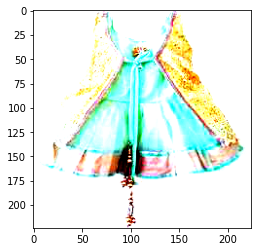

In [ ]:
exemple=21

print(plt.imshow(torchvision.utils.make_grid(test_dl[exemple]['image']).permute(1, 2, 0)))
print(test_dl[exemple]['label'])

In [ ]:

data= iter(test_loader).next()
inputs = data['image'].cuda()
        
inputs = Variable(inputs)

model_ft.eval()
ops = model_ft(test_dl[exemple]['image'].cuda().unsqueeze(0))
print(ops)

y=ops.cpu().detach().numpy()

y_classe=np.where(y<0.5,0,1)

# if y[0][0]<0.65 or abs(y[0][0]-y[0][1])<0.2:
#   y_classe=[0,1]
#     # elif y[0][1]>seuil2 or abs(y[0][0]-y[0][1])<ecart2:
#     #   y_classe=[0,1]
# else:
#   y_classe=[1,0]


# if y[0][0]>0.7 and abs(y[0][0]-y[0][1])>0.4:
#   y_classe=[1,0]
# elif y[0][1]>0.5 or abs(y[0][0]-y[0][1])<0.2:
#   y_classe=[0,1]

y_classe

tensor([[6.4789e-03, 9.9981e-01, 1.6522e-03, 3.4117e-03, 8.6584e-03, 2.9949e-03,
         3.5479e-04]], device='cuda:0', grad_fn=<SigmoidBackward>)


array([[0, 1, 0, 0, 0, 0, 0]])

In [ ]:
#fonction pour récupérer le résultat par seuil:
def resultat_total(seuil,ecart=0.2):

  data= iter(test_loader).next()
  inputs = data['image'].cuda()
          
  inputs = Variable(inputs)

  model_ft.eval()
  res=[]
  for item in test_dl:
    ops = model_ft(item['image'].cuda().unsqueeze(0))

    # ops_1=ops*(1/ops.max())

    y=ops.cpu().detach().numpy()
    y_classe=np.where(y<seuil,0,1)
    

    res.append(y_classe)
  return res

In [ ]:
dict_res={}
for seuil in range(0,110,5):
  dict_res[seuil/100]=resultat_total(seuil/100)
df_res=pd.DataFrame(dict_res)

In [ ]:
df_res

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00,1.05
0,"[[1, 1, 1, 1, 1, 1, 1]]","[[0, 1, 0, 1, 1, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]"
1,"[[1, 1, 1, 1, 1, 1, 1]]","[[1, 1, 0, 0, 0, 0, 1]]","[[1, 1, 0, 0, 0, 0, 1]]","[[1, 1, 0, 0, 0, 0, 1]]","[[1, 1, 0, 0, 0, 0, 1]]","[[1, 1, 0, 0, 0, 0, 1]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]"
2,"[[1, 1, 1, 1, 1, 1, 1]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 1, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]"
3,"[[1, 1, 1, 1, 1, 1, 1]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]"
4,"[[1, 1, 1, 1, 1, 1, 1]]","[[1, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 1, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,"[[1, 1, 1, 1, 1, 1, 1]]","[[1, 1, 0, 0, 1, 1, 1]]","[[1, 1, 0, 0, 1, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 1, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[1, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0]]"
153,"[[1, 1, 1, 1, 1, 1, 1]]","[[0, 0, 1, 0, 0, 0, 0]]","[[0, 0, 1, 0, 0, 0, 0]]","[[0, 0, 1, 0, 0, 0, 0]]","[[0, 0, 1, 0, 0, 0, 0]]","[[0, 0, 1, 0, 0, 0, 0]]","[[0, 0, 1, 0, 0, 0, 0]]","[[0, 0, 1, 0, 0, 0, 0]]","[[0, 0, 1, 0, 0, 0, 0]]","[[0, 0, 1, 0, 0, 0, 0]]","[[0, 0, 1, 0, 0, 0, 0]]","[[0, 0, 1, 0, 0, 0, 0]]","[[0, 0, 1, 0, 0, 0, 0]]","[[0, 0, 

In [ ]:
df_res.drop(1.05,1,inplace=True)
df_res.drop(0.00,1,inplace=True)

In [ ]:
correct=0
corr=[]
for column in df_res.columns.tolist():
  for i,item in enumerate(test_dl):
    if (item['label']==df_res[column][i]).all():
      correct +=1
  corr.append(correct/len(test_dl))
  correct=0

In [ ]:
correct=0
error=0

for i,item in enumerate(test_dl):
    if (item['label']==df_res[0.65][i]).all():
      correct +=1
    else:
      error+=1

In [ ]:
print('taux de prédiction correcte: ',100*(correct/len(test_dl)),'%')
print('taux d\'erreur: ',100*(error/len(test_dl)),'%')

taux de prédiction correcte:  70.70063694267516 %
taux d'erreur:  29.29936305732484 %


In [ ]:
classes_list

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [ ]:
array_Home=[[1,0,0,0,0,0,0]]
array_Baby=[[0,1,0,0,0,0,0]]
array_Watches=[[0,0,1,0,0,0,0]]
array_Festive=[[0,0,0,1,0,0,0]]
array_Kitchen=[[0,0,0,0,1,0,0]]
array_Beauty=[[0,0,0,0,0,1,0]]
array_Computers=[[0,0,0,0,0,0,1]]


array_by_class={
'Home':array_Home,
'Baby':array_Baby,
'Watches':array_Watches,
'Festive':array_Festive,
'Kitchen':array_Kitchen,
'Beauty':array_Beauty,
'Computers':array_Computers
}

In [ ]:
def get_all_image_per_classe(array_classe):
  classe_all=0
  for item in test_dl:
    if (item['label']==array_classe).all():
      classe_all+=1
  return classe_all 

In [ ]:
classes=['Home',
'Baby',
'Watches',
'Festive',
'Kitchen',
'Beauty',
'Computers']

In [ ]:
all_image_per_classe={}
for classe in classes:
    current_result=get_all_image_per_classe(array_by_class[classe])
    all_image_per_classe[classe]=current_result

In [ ]:
total_image_by_class={
'Home':all_image_per_classe['Home'],
'Baby':all_image_per_classe['Baby'],
'Watches':all_image_per_classe['Watches'],
'Festive':all_image_per_classe['Festive'],
'Kitchen':all_image_per_classe['Kitchen'],
'Beauty':all_image_per_classe['Beauty'],
'Computers':all_image_per_classe['Computers']

}

In [ ]:
total_image_by_class

{'Baby': 20,
 'Beauty': 28,
 'Computers': 20,
 'Festive': 19,
 'Home': 25,
 'Kitchen': 25,
 'Watches': 20}

In [ ]:
def df_classe_correct(array_classe,all_classe):
  classe_corr=0
  dict_res_classe={}
  for seuil in df_res.columns.tolist():
    for i,item in enumerate(test_dl):
      if (item['label']==df_res[seuil][i]).all() and (df_res[seuil][i]==array_classe).all():
        classe_corr+=1
      else:
        classe_corr+=0
        dict_res_classe[seuil]=classe_corr/all_classe
    
    classe_corr=0

  df_res_classe=pd.DataFrame(dict_res_classe,index=[0])
  return df_res_classe

In [ ]:
df_classe_correct(array_by_class['Home'],total_image_by_class['Home'])

,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
0,0.24,0.4,0.48,0.48,0.48,0.48,0.56,0.56,0.6,0.72,0.72,0.72,0.76,0.76,0.76,0.76,0.8,0.76,0.68,0.0


In [ ]:
df_classe_correct(array_by_class['Baby'],total_image_by_class['Baby'])

,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
0,0.25,0.4,0.4,0.5,0.55,0.55,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.65,0.6,0.6,0.6,0.6,0.6,0.0


In [ ]:
accuracies={}
for classe in classes:
    current_result=df_classe_correct(array_by_class[classe],total_image_by_class[classe])
    accuracies[classe]=current_result


In [ ]:
print(df_res.columns.tolist())
print(corr)

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
[0.3503184713375796, 0.4840764331210191, 0.5414012738853503, 0.5859872611464968, 0.5923566878980892, 0.5987261146496815, 0.6369426751592356, 0.6369426751592356, 0.6560509554140127, 0.6815286624203821, 0.6878980891719745, 0.6942675159235668, 0.7070063694267515, 0.7133757961783439, 0.7070063694267515, 0.7261146496815286, 0.732484076433121, 0.7070063694267515, 0.6560509554140127, 0.0]


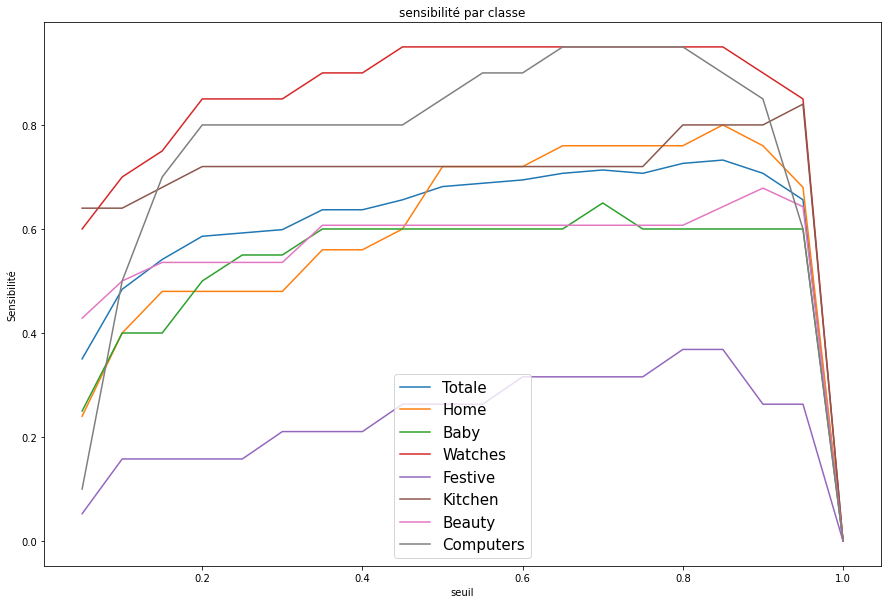

In [ ]:
plt.figure(figsize=(15, 10))
plt.title("sensibilité par classe",)
plt.plot(df_res.columns.tolist(),corr,label="Totale")
plt.plot(df_res.columns.tolist(),accuracies['Home'].T[0],label="Home")
plt.plot(df_res.columns.tolist(),accuracies['Baby'].T[0],label="Baby")
plt.plot(df_res.columns.tolist(),accuracies['Watches'].T[0],label="Watches")
plt.plot(df_res.columns.tolist(),accuracies['Festive'].T[0],label="Festive")
plt.plot(df_res.columns.tolist(),accuracies['Kitchen'].T[0],label="Kitchen")
plt.plot(df_res.columns.tolist(),accuracies['Beauty'].T[0],label="Beauty")
plt.plot(df_res.columns.tolist(),accuracies['Computers'].T[0],label="Computers")



plt.xlabel("seuil")
plt.ylabel("Sensibilité")
plt.legend(fontsize =15)

In [ ]:
def y_test_list(array_classe):
  y_test_classe=[]
  y=0
  for i,item in enumerate(test_dl):
    if (item['label']==array_classe).all():
        y=1
    else:
      y=0
    y_test_classe.append(y)
  return y_test_classe

In [ ]:
# seuil=0,8 ou nous allons le racall total max:
def y_pred_list(array_classe):
  y_pred_classe=[]
  y=0
  for i in range(len(test_dl)):
    if (df_res[0.8][i]==array_classe).all():
      y=1
    else:
      y=0
    y_pred_classe.append(y)
  return y_pred_classe

In [ ]:
y_test_all_data=[]
for item in test_dl:
  y_test_all_data.append(item['label'])

In [ ]:

y_test_Home=y_test_list(array_Home)
y_pred_Home=y_pred_list(array_Home)

y_test_Baby=y_test_list(array_Baby)
y_pred_Baby=y_pred_list(array_Baby)

y_test_Watches=y_test_list(array_Watches)
y_pred_Watches=y_pred_list(array_Watches)

y_test_Festive=y_test_list(array_Festive)
y_pred_Festive=y_pred_list(array_Festive)

y_test_Kitchen=y_test_list(array_Kitchen)
y_pred_Kitchen=y_pred_list(array_Kitchen)

y_test_Beauty=y_test_list(array_Beauty)
y_pred_Beauty=y_pred_list(array_Beauty)

y_test_Computers=y_test_list(array_Computers)
y_pred_Computers=y_pred_list(array_Computers)


In [ ]:
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,recall_score

# Matrice de confusion et Racall, F1 score et accuracy pour chaque catégories:

cm_Home=confusion_matrix(y_test_Home,y_pred_Home)
rec_Home=recall_score(y_test_Home,y_pred_Home)
f_Home=f1_score(y_test_Home,y_pred_Home)
acc_Home=accuracy_score(y_test_Home,y_pred_Home)


cm_Baby=confusion_matrix(y_test_Baby,y_pred_Baby)
rec_Baby=recall_score(y_test_Baby,y_pred_Baby)
f_Baby=f1_score(y_test_Baby,y_pred_Baby)
acc_Baby=accuracy_score(y_test_Baby,y_pred_Baby)


cm_Watches=confusion_matrix(y_test_Watches,y_pred_Watches)
rec_Watches=recall_score(y_test_Watches,y_pred_Watches)
f_Watches=f1_score(y_test_Watches,y_pred_Watches)
acc_Watches=accuracy_score(y_test_Watches,y_pred_Watches)

cm_Festive=confusion_matrix(y_test_Festive,y_pred_Festive)
rec_Festive=recall_score(y_test_Festive,y_pred_Festive)
f_Festive=f1_score(y_test_Festive,y_pred_Festive)
acc_Festive=accuracy_score(y_test_Festive,y_pred_Festive)

cm_Kitchen=confusion_matrix(y_test_Kitchen,y_pred_Kitchen)
rec_Kitchen=recall_score(y_test_Kitchen,y_pred_Kitchen)
f_Kitchen=f1_score(y_test_Kitchen,y_pred_Kitchen)
acc_Kitchen=accuracy_score(y_test_Kitchen,y_pred_Kitchen)

cm_Beauty=confusion_matrix(y_test_Beauty,y_pred_Beauty)
rec_Beauty=recall_score(y_test_Beauty,y_pred_Beauty)
f_Beauty=f1_score(y_test_Beauty,y_pred_Beauty)
acc_Beauty=accuracy_score(y_test_Beauty,y_pred_Beauty)

cm_Computers=confusion_matrix(y_test_Computers,y_pred_Computers)
rec_Computers=recall_score(y_test_Computers,y_pred_Computers)
f_Computers=f1_score(y_test_Computers,y_pred_Computers)
acc_Computers=accuracy_score(y_test_Computers,y_pred_Computers)

print('----------------------------------------------------------')
print('Pour la classe Home Furnishing : \n Confusion_matrix:\n' ,cm_Home,'\n Recall:\n',rec_Home ,'\n F1_score:\n ',f_Home,'\n Accuracy:\n ',acc_Home)
print('----------------------------------------------------------')
print('Pour la classe Baby Care :\n Confusion_matrix:\n' ,cm_Baby,'\n Recall:\n',rec_Baby ,'\n F1_score:\n ',f_Baby,'\n Accuracy:\n ',acc_Baby)
print('----------------------------------------------------------')
print('Pour la classe Watches :\n Confusion_matrix:\n' ,cm_Watches,'\n Recall:\n',rec_Watches ,'\n F1_score:\n ',f_Watches,'\n Accuracy:\n ',acc_Watches)
print('----------------------------------------------------------')
print('Pour la classe Home Decor & Festive Needs :\n Confusion_matrix:\n' ,cm_Festive,'\n Recall:\n',rec_Festive ,'\n F1_score:\n ',f_Festive,'\n Accuracy:\n ',acc_Festive)
print('----------------------------------------------------------')
print('Pour la classe Kitchen & Dining :\n Confusion_matrix:\n' ,cm_Kitchen,'\n Recall:\n',rec_Kitchen ,'\n F1_score:\n ',f_Kitchen,'\n Accuracy:\n ',acc_Kitchen)
print('----------------------------------------------------------')
print('Pour la classe Beauty and Personal Care :\n Confusion_matrix:\n' ,cm_Beauty,'\n Recall:\n',rec_Beauty ,'\n F1_score:\n ',f_Beauty,'\n Accuracy:\n ',acc_Beauty)
print('----------------------------------------------------------')
print('Pour la classe Computers :\n Confusion_matrix:\n' ,cm_Computers,'\n Recall:\n',rec_Computers ,'\n F1_score:\n ',f_Computers,'\n Accuracy:\n ',acc_Computers)



----------------------------------------------------------
Pour la classe Home Furnishing : 
 Confusion_matrix:
 [[119  13]
 [  5  20]] 
 Recall:
 0.8 
 F1_score:
  0.689655172413793 
 Accuracy:
  0.8853503184713376
----------------------------------------------------------
Pour la classe Baby Care :
 Confusion_matrix:
 [[137   0]
 [  8  12]] 
 Recall:
 0.6 
 F1_score:
  0.7499999999999999 
 Accuracy:
  0.9490445859872612
----------------------------------------------------------
Pour la classe Watches :
 Confusion_matrix:
 [[136   1]
 [  1  19]] 
 Recall:
 0.95 
 F1_score:
  0.9500000000000001 
 Accuracy:
  0.9872611464968153
----------------------------------------------------------
Pour la classe Home Decor & Festive Needs :
 Confusion_matrix:
 [[137   1]
 [ 12   7]] 
 Recall:
 0.3684210526315789 
 F1_score:
  0.5185185185185185 
 Accuracy:
  0.9171974522292994
----------------------------------------------------------
Pour la classe Kitchen & Dining :
 Confusion_matrix:
 [[129   3]

In [ ]:
# Calcul des même coef pour l'ensemble des images:
import statistics
rec_total=statistics.mean([rec_Home,rec_Baby,rec_Watches,rec_Festive,rec_Kitchen,rec_Beauty,rec_Computers])
f1_score_total=statistics.mean([f_Home,f_Baby,f_Watches,f_Festive,f_Kitchen,f_Beauty,f_Computers])
acc_total=statistics.mean([acc_Home,acc_Baby,acc_Watches,acc_Festive,acc_Kitchen,acc_Beauty,acc_Computers])
print('recall total: ',rec_total,'\n','F1_score: ',f1_score_total,'\n','Accuracy: ',acc_total)

recall total:  0.7250805585392052 
 F1_score:  0.7634676889549453 
 Accuracy:  0.9390354868061874


# Conclusion:

Pour conclure, j'ai essayé d'étudier la faisabilité d'automatisation la classification des articles vendues, en me basant sur les données textuelles ou visuelles.

J'ai commencé par traiter les données textuelles, et pour ce, nous avons utilisé les méthodes:

  - Bag of Words ==> ARI=0,38
  - Tf-idf ==> ARI=0,35
  - LDA ==> ARI=0,14

Par la suite j'ai traiter les données visuelles avec les méthodes :

  - ORB + BoVW ==> ARI=0,049
  - SIFT ==> ARI=0,041

Vu que ces méthodes ne m'ont pas donné des résultats satisfaisant, j'ai restructuré les données afin d'avoir une base de données d'images étiquettées, et sur cette base, j'ai entrainé la dernière couche du model densNet (un model CNN) et j'ai réussi à avoir une accuracy total de 0,93% ce qui représente un résultat encouragent pour mieux creuser dans ce sens afin d'obtenir une classification automatique des produits basée sur lesimages.
 
